# Trains a model which returns whether a message is a request for help

In [1]:
# Imports
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import os
import requests
import sys
import random
import pydot
import csv
import re
import string

from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import display
from PIL import Image
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from tqdm.notebook import trange, tqdm
from datetime import datetime
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [2]:
# Parameters
BATCH_SIZE = 64
VALIDATION_RATIO=0.1
MODEL_NAME = "help_and_support"
LABELS = ["Yes", "No"]

EPOCHS = 25

In [3]:
# Gather input data

columns = ['is_help_request', 'text']
input_columns = len(columns)
rows = []

url = "https://docs.google.com/spreadsheets/d/1qKpHCNOVqBrU1OxFLgV_Z0lEE0cJTdOdm-aZ1soDaag/export?format=csv&gid=1802577011"

csvfile = requests.get(url).content.decode('utf-8')

reader = csv.reader(csvfile.splitlines(), delimiter=",", )
next(reader) # Skip header
for row in reader:
    if len(row) == 0:
        continue
    rows.append(
        list(row.copy())
    )

print(F"Read {len(rows)} rows")
num_rows = len(rows)
np.random.seed(0)
np.random.shuffle(rows)

# Generate class weights
class_counts = []
class_counts.append(sum(map(lambda x: 1 if int(x[0]) == 0 else 0, rows)))
class_counts.append(sum(map(lambda x: 1 if int(x[0]) == 1 else 0, rows)))

class_weights = {}
for i, e in enumerate(class_counts):
   class_weights[i] = (class_counts[i] / num_rows)
print(F"Class weight result: {class_weights}")

# Create a new Numpy array with just labels
inputs = np.array(list(
    map(lambda x: x[1], rows.copy()
)))
labels = np.array(list(
    map(lambda x: float(x[0]), rows.copy()
)))
print(F"Loaded {class_counts[0]} false and {class_counts[1]} true rows")

# Create a dataset & split it into training & validation
dataset = tf.data.Dataset.from_tensor_slices((inputs, labels))
val_size = int(num_rows * VALIDATION_RATIO)
print(F"Creating training dataset n={num_rows - val_size}")
print(F"Creating validation dataset n={val_size}")
raw_train_ds = dataset.skip(val_size).batch(BATCH_SIZE)
raw_val_ds = dataset.take(val_size).batch(BATCH_SIZE)

# Vectorize inputs
max_features = 3000
sequence_length = 150

vectorize_layer = layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

Read 802 rows
Class weight result: {0: 0.5, 1: 0.5}
Loaded 401 false and 401 true rows


2023-04-21 23:08:14.952931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 23:08:15.101617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 23:08:15.102032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 23:08:15.104522: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Creating training dataset n=722
Creating validation dataset n=80


In [10]:
# Define models

# A small embedding is a reasonable choice for our small dataset. If we grow past ~5000 examples, maybe tick this up a bit.
embedding_dim = 64

models = {}
models['simple'] = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim, mask_zero=False),
  layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim * 2, return_sequences=True)),
  layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim * 2, return_sequences=True)),
  layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim * 1)),
  layers.Dropout(.1),
  layers.Dense(embedding_dim, activation='relu'),
  layers.Dropout(.2),
  layers.Dense(1),
])
models['simple'].summary()
models['simple'].compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=tf.metrics.BinaryAccuracy(threshold=0.8))

for name, model in models.items():
    tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 64)          192064    
                                                                 
 bidirectional_10 (Bidirecti  (None, None, 256)        197632    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, None, 256)        394240    
 onal)                                                           
                                                                 
 bidirectional_12 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                      

Fitting simple...


Training:   0%|                                                                                               …

Epoch 1/15


0/12                                                                                                          …

Epoch 2/15


0/12                                                                                                          …

Epoch 3/15


0/12                                                                                                          …

Epoch 4/15


0/12                                                                                                          …

Epoch 5/15


0/12                                                                                                          …

Epoch 6/15


0/12                                                                                                          …

Epoch 7/15


0/12                                                                                                          …

Epoch 8/15


0/12                                                                                                          …

Epoch 9/15


0/12                                                                                                          …

Epoch 10/15


0/12                                                                                                          …

Epoch 11/15


0/12                                                                                                          …

Epoch 12/15


0/12                                                                                                          …

Epoch 13/15


0/12                                                                                                          …

Epoch 14/15


0/12                                                                                                          …

Epoch 15/15


0/12                                                                                                          …

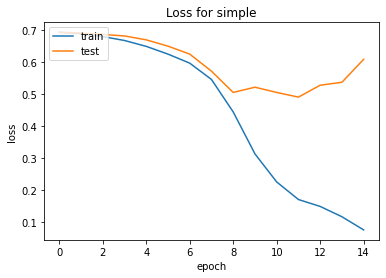

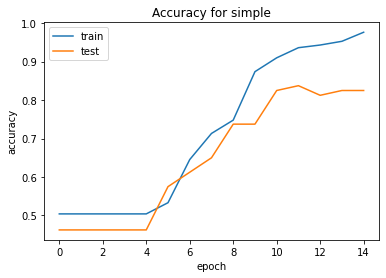

In [11]:
# Fit the model
for name, model in models.items():
    print(F"Fitting {name}...")
    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=15,
      callbacks=[
          tfa.callbacks.TQDMProgressBar(),
          keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
      ],
      #class_weight=class_weights,
      verbose=0,
    )
    # Show the loss over time
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(F'Loss for {name}')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # Show accuracy
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title(F'Accuracy for {name}')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [12]:
# Create a model that's ready to use

export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=tf.losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Save it
export_model.save(F'../saved_model/{MODEL_NAME}_' + name + datetime.now().strftime('%Y-%m-%dT%H:%M:%S.%f%z'))

# Test it
inputs = [
    "Hey guys, I'm new here, can I get some help setting up ELRS?",
    "I can't seem to get my Mobula 6 to bind with my TX16S",
    "Can anyone help me figure out why my link drops when I use VTX Admin?",
    "I just got a Crux 3 and can't figure out how to set up the SPI receiver, anyone know how to do that?",
    "Is there anyone here who has experience with the Crux 3 and the Jumper T-Pro?",
    "How do I turn off model match?",
    "How do I flash an RX with the TX firmware?",
    "Hi guys, I'm new to ELRS and excited to fly since I'm all set up!",
    "Thanks for all the help and support!",
    "Hey guys how's everyone doing?",
    "Why would I want to use that?",
    "I solder things with a copper block",
    "What time is it?",
    "A TCXO is a fixed-frequency crystal, not affected by temperature",
    "Could you do me a favor?",
    "Should I take general chat maybe?",
    "You should connect to the WiFi and use the /hardware.html page",
    "Thanks for the link! That's awesome",
    "What?",
]

results = export_model.predict(inputs, verbose=0)
results_percentages = list(map(lambda x: round(x[0] * 100), results.tolist()))
for i in range(len(results)):
    print(f"{results_percentages[i]}% confidence: \"{inputs[i]}\" ") 

INFO:tensorflow:Assets written to: ../saved_model/help_and_support_simple2023-04-21T23:26:41.282993/assets


INFO:tensorflow:Assets written to: ../saved_model/help_and_support_simple2023-04-21T23:26:41.282993/assets


99% confidence: "Hey guys, I'm new here, can I get some help setting up ELRS?" 
99% confidence: "I can't seem to get my Mobula 6 to bind with my TX16S" 
99% confidence: "Can anyone help me figure out why my link drops when I use VTX Admin?" 
93% confidence: "I just got a Crux 3 and can't figure out how to set up the SPI receiver, anyone know how to do that?" 
97% confidence: "Is there anyone here who has experience with the Crux 3 and the Jumper T-Pro?" 
90% confidence: "How do I turn off model match?" 
99% confidence: "How do I flash an RX with the TX firmware?" 
98% confidence: "Hi guys, I'm new to ELRS and excited to fly since I'm all set up!" 
1% confidence: "Thanks for all the help and support!" 
5% confidence: "Hey guys how's everyone doing?" 
1% confidence: "Why would I want to use that?" 
3% confidence: "I solder things with a copper block" 
2% confidence: "What time is it?" 
1% confidence: "A TCXO is a fixed-frequency crystal, not affected by temperature" 
6% confidence: "Coul